In [145]:
# Imports
import pandas as pd
import numpy as np
from binance.client import Client as bnb_client
import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
# Data Fetching Function
def get_data(symbol, interval, lookback):
    """Get historical data from Binance"""
    client = bnb_client(tld='US')
    klines = client.get_historical_klines(symbol, interval, lookback)
    
    df = pd.DataFrame(klines, columns=['open_time', 'open', 'high', 'low', 'close', 'volume',
                                     'close_time', 'quote_volume', 'trades', 'taker_buy_base',
                                     'taker_buy_quote', 'ignore'])
    
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df.set_index('open_time', inplace=True)
    
    for col in ['close', 'volume']:
        df[col] = pd.to_numeric(df[col])
    
    return df[['close', 'volume']]

In [151]:
# Helper Functions
def calculate_signals(returns, volumes, lookback=20):
    """Calculate volume-adjusted momentum signals"""
    signals = pd.DataFrame(index=returns.index, columns=returns.columns)
    
    for col in returns.columns:
        mom = returns[col].rolling(lookback).mean()
        vol_ma = volumes[col].rolling(lookback).mean()
        vol_ratio = volumes[col] / vol_ma
        signals[col] = mom * np.sqrt(vol_ratio)
    
    return signals

def calculate_stop_losses(returns, window=20):
    """Calculate moving stop-loss levels"""
    rolling_low = returns.rolling(window).min()
    rolling_vol = returns.rolling(window).std()
    vol_regime = (rolling_vol / rolling_vol.rolling(100).mean()).clip(0.5, 2.0)
    stop_levels = rolling_low - (2 * rolling_vol / np.sqrt(vol_regime))
    return stop_levels

def get_portfolio_weights(signals, returns, lookback=20):
    """Get portfolio weights with enhanced risk management"""
    ranked = signals.rank(axis=1, pct=True)
    zscore = (ranked - 0.5) / ranked.std(axis=1).replace(0, 1).values.reshape(-1, 1)
    
    weights = pd.DataFrame(0, index=signals.index, columns=signals.columns)
    weights[zscore > 1.5] = 1
    weights[zscore < -1.5] = -1
    
    stop_losses = calculate_stop_losses(returns)
    recent_returns = returns.rolling(5).sum()
    
    for col in weights.columns:
        stop_condition = (recent_returns[col] < stop_losses[col]) & (weights[col] != 0)
        extreme_neg_mom = returns[col].rolling(3).mean() < -3 * returns[col].rolling(60).std()
        weights.loc[stop_condition | extreme_neg_mom, col] = 0
    
    vol = returns.rolling(lookback).std() * np.sqrt(252)
    target_vol = 0.3
    vol_scalar = (target_vol / vol).clip(0.5, 2.0)
    weights = weights.multiply(vol_scalar, axis=0)
    
    correlations = returns.rolling(lookback).corr()
    avg_corr = correlations.groupby(level=0).mean().mean(axis=1)
    corr_scalar = ((1 - avg_corr) + 0.2).clip(0.5, 1.2)
    weights = weights.multiply(corr_scalar, axis=0)
    
    weights_vol_adj = weights.multiply(1 / vol)
    pos_sum = weights_vol_adj.abs().sum(axis=1)
    weights = weights.divide(pos_sum.replace(0, 1), axis=0)
    
    return weights

In [153]:
# Fetch Data
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT']
lookback = '700 days ago UTC'

data = {}
for symbol in symbols:
    data[symbol] = get_data(symbol, '1d', lookback)

In [154]:
# Display Raw Data for BTC
data['BTCUSDT']

,close,volume
open_time,,
2023-02-19,24263.00,1744.260125
2023-02-20,24838.09,1988.734029
2023-02-21,24453.24,2484.635281
2023-02-22,24181.73,2155.166063
2023-02-23,23937.75,2680.622008
...,...,...
2025-01-14,96535.75,22.637980
2025-01-15,100387.65,26.396970
2025-01-16,99877.55,20.192650


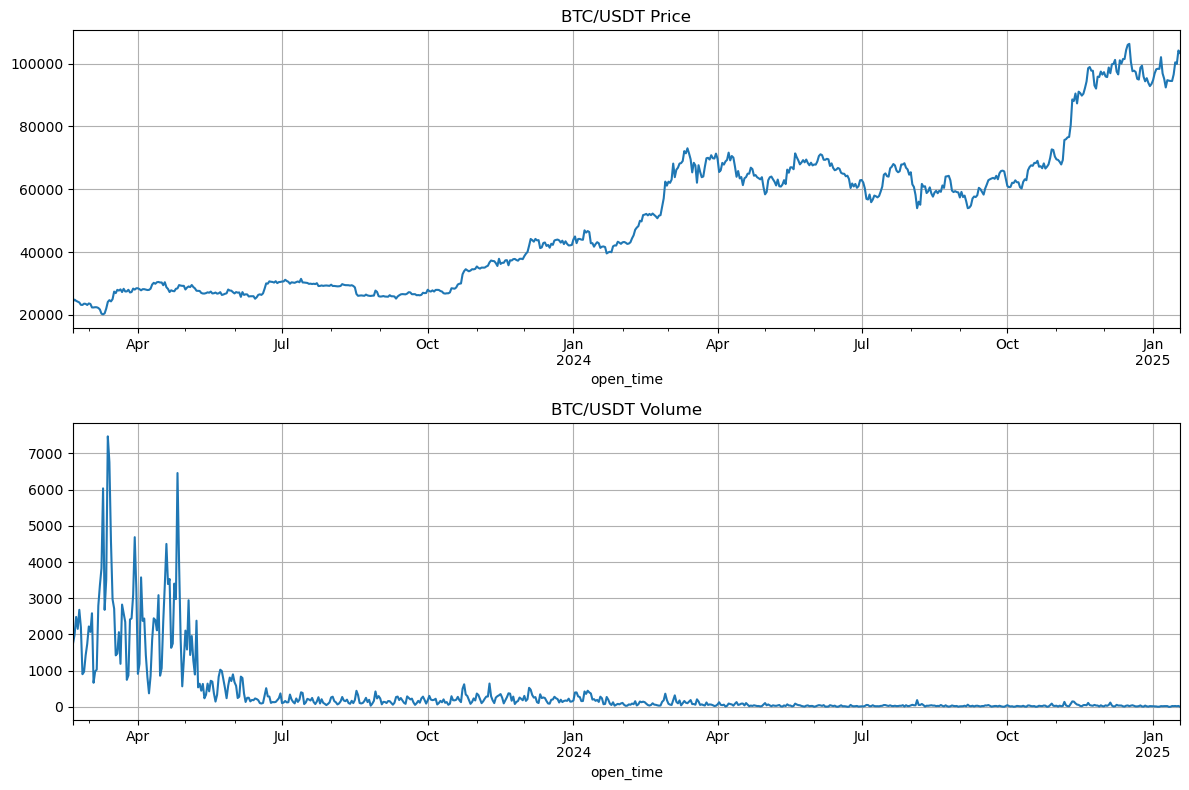

In [155]:
# Plot BTC Data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
data['BTCUSDT']['close'].plot(ax=ax1)
ax1.set_title('BTC/USDT Price')
ax1.grid(True)
data['BTCUSDT']['volume'].plot(ax=ax2)
ax2.set_title('BTC/USDT Volume')
ax2.grid(True)
plt.tight_layout()
plt.show()


In [156]:
# Create and Display Price DataFrame
prices = pd.DataFrame({s: data[s]['close'] for s in symbols})
prices

,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,ADAUSDT
open_time,,,,,
2023-02-19,24263.00,1681.18,311.9248,24.8183,0.39968
2023-02-20,24838.09,1703.27,315.3562,26.2392,0.40306
2023-02-21,24453.24,1659.74,311.4537,24.9738,0.39245
2023-02-22,24181.73,1643.49,312.5363,24.1517,0.38892
2023-02-23,23937.75,1650.45,308.4659,23.9391,0.38286
...,...,...,...,...,...
2025-01-14,96535.75,3223.11,697.9800,187.7000,0.99740
2025-01-15,100387.65,3451.98,713.0800,205.8500,1.07880
2025-01-16,99877.55,3311.09,703.2200,210.8600,1.09000


In [157]:
# Create and Display Volume DataFrame
volumes = pd.DataFrame({s: data[s]['volume'] for s in symbols})
volumes

,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,ADAUSDT
open_time,,,,,
2023-02-19,1744.260125,9702.51230,1051.900,84165.390,2684832.2
2023-02-20,1988.734029,8935.53342,1685.000,85430.980,2126291.4
2023-02-21,2484.635281,15930.65629,2074.300,55458.480,2084612.4
2023-02-22,2155.166063,15189.80600,1498.400,42542.730,2001523.0
2023-02-23,2680.622008,13275.23390,1102.100,24645.010,2010291.3
...,...,...,...,...,...
2025-01-14,22.637980,238.75890,401.429,2436.988,1122104.0
2025-01-15,26.396970,359.33740,381.284,8318.585,2204751.0
2025-01-16,20.192650,323.18000,426.787,9797.915,1701621.3


In [158]:
# Calculate and Display Returns
returns = prices.pct_change()
returns

,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,ADAUSDT
open_time,,,,,
2023-02-19,NaN,NaN,NaN,NaN,NaN
2023-02-20,0.023702,0.013140,0.011001,0.057252,0.008457
2023-02-21,-0.015494,-0.025557,-0.012375,-0.048226,-0.026324
2023-02-22,-0.011103,-0.009791,0.003476,-0.032918,-0.008995
2023-02-23,-0.010089,0.004235,-0.013024,-0.008803,-0.015582
...,...,...,...,...,...
2025-01-14,0.022152,0.029274,0.015007,0.026132,0.055226
2025-01-15,0.039901,0.071009,0.021634,0.096697,0.081612
2025-01-16,-0.005081,-0.040814,-0.013827,0.024338,0.010382


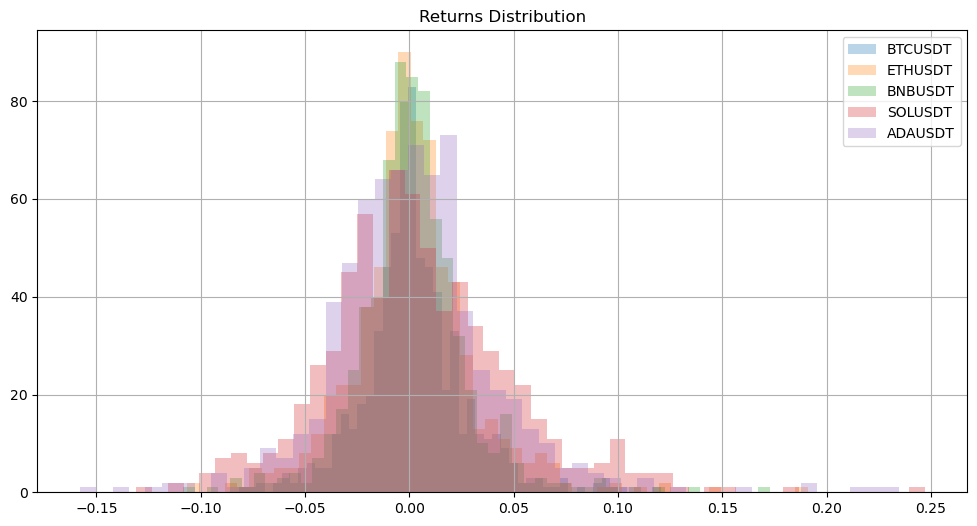

In [159]:
# Plot Returns Distribution
plt.figure(figsize=(12, 6))
for col in returns.columns:
    plt.hist(returns[col].dropna(), bins=50, alpha=0.3, label=col)
plt.title('Returns Distribution')
plt.legend()
plt.grid(True)
plt.show()

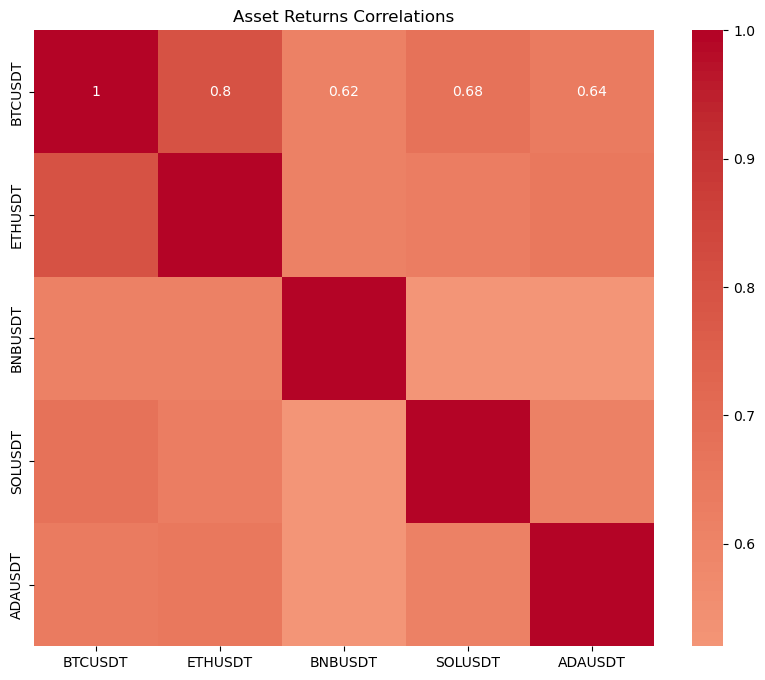

In [160]:
# Correlation Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Asset Returns Correlations')
plt.show()

In [161]:
# Calculate and Display Signals
signals = calculate_signals(returns, volumes)
signals

,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,ADAUSDT
open_time,,,,,
2023-02-19,NaN,NaN,NaN,NaN,NaN
2023-02-20,NaN,NaN,NaN,NaN,NaN
2023-02-21,NaN,NaN,NaN,NaN,NaN
2023-02-22,NaN,NaN,NaN,NaN,NaN
2023-02-23,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-01-14,-0.001351,-0.004169,-0.000050,-0.001201,0.006660
2025-01-15,0.003067,0.003121,0.001900,0.006035,0.020366
2025-01-16,0.003317,0.000304,0.001278,0.009360,0.016613


<Figure size 1200x600 with 0 Axes>

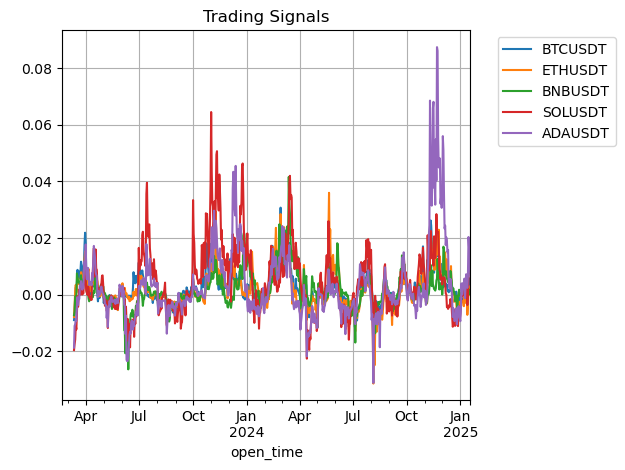

In [162]:
# Plot Signals
plt.figure(figsize=(12, 6))
signals.plot()
plt.title('Trading Signals')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [163]:
# Calculate and Display Portfolio Weights
weights = get_portfolio_weights(signals, returns)
weights

,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,ADAUSDT
open_time,,,,,
2023-02-19,NaN,NaN,NaN,NaN,NaN
2023-02-20,NaN,NaN,NaN,NaN,NaN
2023-02-21,NaN,NaN,NaN,NaN,NaN
2023-02-22,NaN,NaN,NaN,NaN,NaN
2023-02-23,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-01-14,0.0,0.0,0.0,0.000000,0.864584
2025-01-15,0.0,0.0,0.0,0.000000,0.864885
2025-01-16,0.0,0.0,0.0,0.000000,0.864573


<Figure size 1200x600 with 0 Axes>

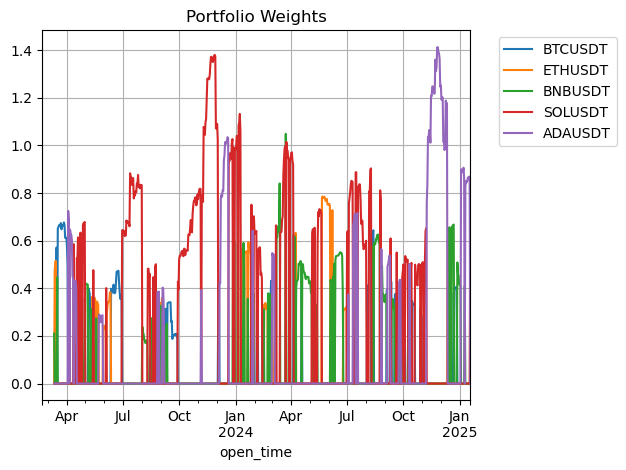

In [164]:
# Plot Portfolio Weights
plt.figure(figsize=(12, 6))
weights.plot()
plt.title('Portfolio Weights')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

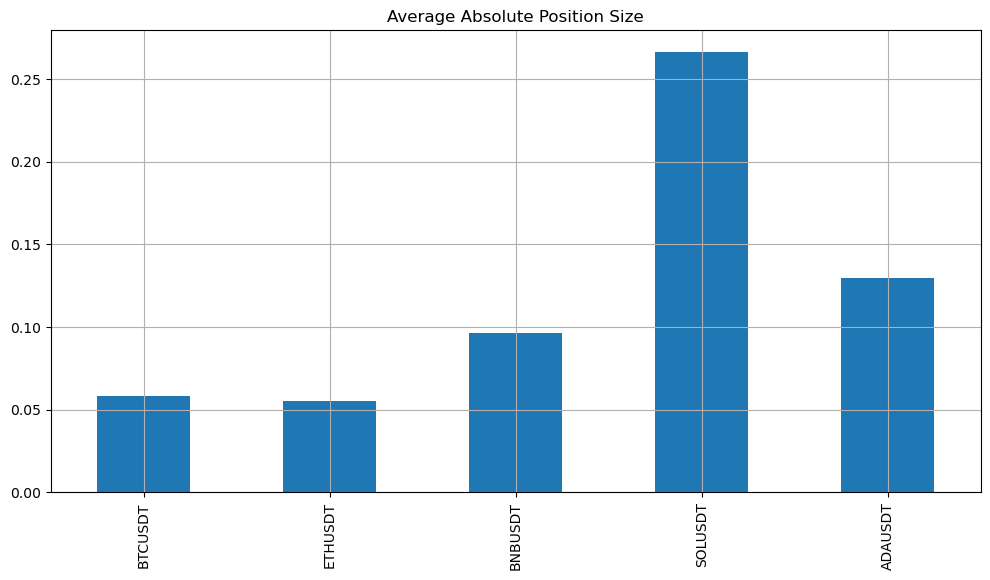

In [165]:
# Plot Weight Distribution
plt.figure(figsize=(12, 6))
weights.abs().mean().plot(kind='bar')
plt.title('Average Absolute Position Size')
plt.grid(True)
plt.show()

In [166]:
# Calculate and Display Strategy Returns
strat_rets_gross = (weights.shift() * returns).sum(axis=1)
pd.DataFrame({'Gross Returns': strat_rets_gross})

,Gross Returns
open_time,
2023-02-19,0.000000
2023-02-20,0.000000
2023-02-21,0.000000
2023-02-22,0.000000
2023-02-23,0.000000
...,...
2025-01-14,0.046871
2025-01-15,0.070561
2025-01-16,0.008979


In [167]:
# Calculate and Display Transaction Costs
turnover = weights.diff().abs().sum(axis=1)
costs = turnover * 0.002
strat_rets_net = strat_rets_gross - costs

pd.DataFrame({
    'Turnover': turnover,
    'Transaction Costs': costs
})

,Turnover,Transaction Costs
open_time,,
2023-02-19,0.000000,0.000000e+00
2023-02-20,0.000000,0.000000e+00
2023-02-21,0.000000,0.000000e+00
2023-02-22,0.000000,0.000000e+00
2023-02-23,0.000000,0.000000e+00
...,...,...
2025-01-14,0.015877,3.175473e-05
2025-01-15,0.000301,6.011790e-07
2025-01-16,0.000312,6.234114e-07


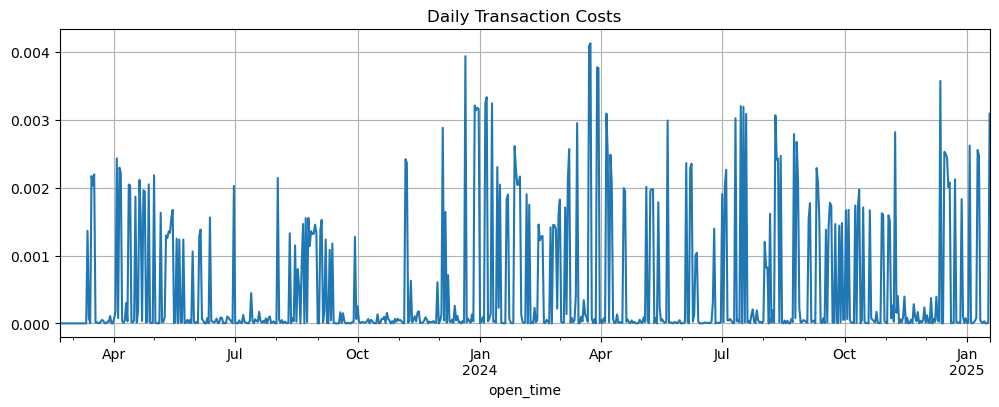

In [168]:
# Plot Transaction Costs
plt.figure(figsize=(12, 4))
costs.plot()
plt.title('Daily Transaction Costs')
plt.grid(True)
plt.show()

In [169]:
# Calculate and Display Cumulative Returns
cum_rets_gross = (1 + strat_rets_gross).cumprod()
cum_rets_net = (1 + strat_rets_net).cumprod()
cum_rets_btc = (1 + returns['BTCUSDT']).cumprod()

pd.DataFrame({
    'Gross Strategy': cum_rets_gross,
    'Net Strategy': cum_rets_net,
    'BTC/USD': cum_rets_btc
})

,Gross Strategy,Net Strategy,BTC/USD
open_time,,,
2023-02-19,1.000000,1.000000,NaN
2023-02-20,1.000000,1.000000,1.023702
2023-02-21,1.000000,1.000000,1.007841
2023-02-22,1.000000,1.000000,0.996650
2023-02-23,1.000000,1.000000,0.986595
...,...,...,...
2025-01-14,11.602051,8.180537,3.978723
2025-01-15,12.420699,8.757756,4.137479
2025-01-16,12.532226,8.836388,4.116455


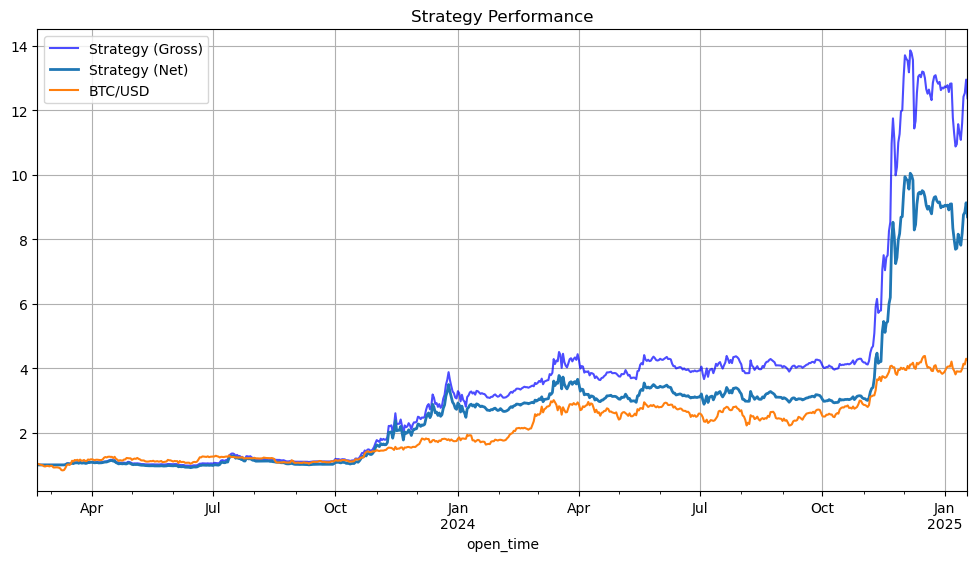

In [170]:
# Plot Strategy Performance
plt.figure(figsize=(12, 6))
cum_rets_gross.plot(label='Strategy (Gross)', color='blue', alpha=0.7)
cum_rets_net.plot(label='Strategy (Net)', linewidth=2)
cum_rets_btc.plot(label='BTC/USD')
plt.title('Strategy Performance')
plt.legend()
plt.grid(True)
plt.show()

In [171]:
# Calculate and Display Drawdowns
drawdowns = pd.DataFrame({
    'Gross Strategy': (cum_rets_gross / cum_rets_gross.expanding().max() - 1),
    'Net Strategy': (cum_rets_net / cum_rets_net.expanding().max() - 1),
    'BTC/USD': (cum_rets_btc / cum_rets_btc.expanding().max() - 1)
})
drawdowns

,Gross Strategy,Net Strategy,BTC/USD
open_time,,,
2023-02-19,0.000000,0.000000,NaN
2023-02-20,0.000000,0.000000,0.000000
2023-02-21,0.000000,0.000000,-0.015494
2023-02-22,0.000000,0.000000,-0.026426
2023-02-23,0.000000,0.000000,-0.036248
...,...,...,...
2025-01-14,-0.162787,-0.185760,-0.091557
2025-01-15,-0.103713,-0.128307,-0.055309
2025-01-16,-0.095665,-0.120480,-0.060109


<Figure size 1200x600 with 0 Axes>

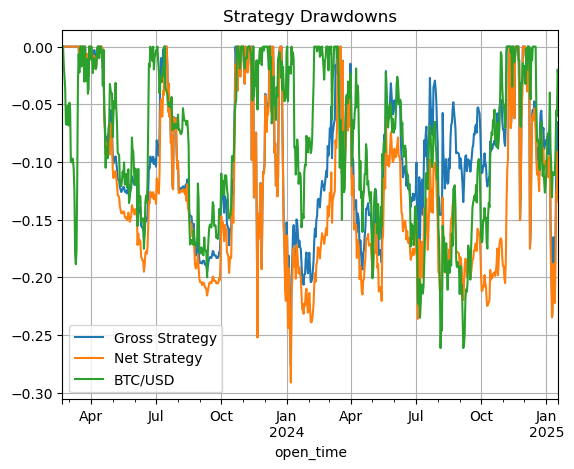

In [172]:
# Plot Drawdowns
plt.figure(figsize=(12, 6))
drawdowns.plot()
plt.title('Strategy Drawdowns')
plt.grid(True)
plt.show()

In [173]:
# Calculate and Display Rolling Metrics
# Rolling Sharpe Ratio (252-day)
rolling_sharpe = np.sqrt(252) * returns.rolling(252).mean() / returns.rolling(252).std()
rolling_sharpe

,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,ADAUSDT
open_time,,,,,
2023-02-19,NaN,NaN,NaN,NaN,NaN
2023-02-20,NaN,NaN,NaN,NaN,NaN
2023-02-21,NaN,NaN,NaN,NaN,NaN
2023-02-22,NaN,NaN,NaN,NaN,NaN
2023-02-23,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-01-14,1.272741,0.391999,0.653398,0.685675,1.475130
2025-01-15,1.412186,0.538268,0.666644,0.886952,1.541681
2025-01-16,1.328137,0.425796,0.594722,0.818291,1.523767


<Figure size 1200x600 with 0 Axes>

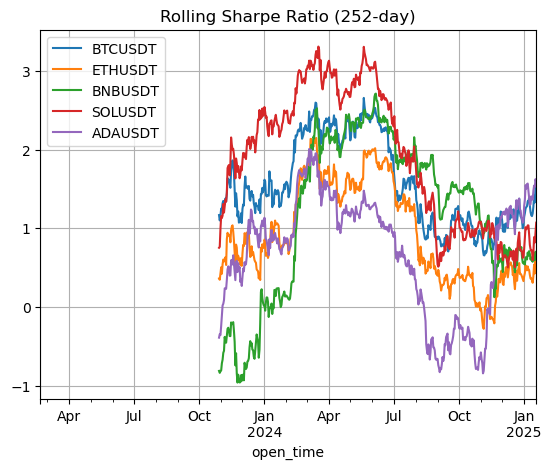

In [174]:
# Plot Rolling Sharpe
plt.figure(figsize=(12, 6))
rolling_sharpe.plot()
plt.title('Rolling Sharpe Ratio (252-day)')
plt.grid(True)
plt.show()

In [175]:
# Calculate and Display Rolling Correlations
rolling_corr = returns.rolling(63).corr(returns['BTCUSDT'])
rolling_corr

,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,ADAUSDT
open_time,,,,,
2023-02-19,NaN,NaN,NaN,NaN,NaN
2023-02-20,NaN,NaN,NaN,NaN,NaN
2023-02-21,NaN,NaN,NaN,NaN,NaN
2023-02-22,NaN,NaN,NaN,NaN,NaN
2023-02-23,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-01-14,1.0,0.701249,0.491586,0.675276,0.561210
2025-01-15,1.0,0.734926,0.505281,0.691946,0.577627
2025-01-16,1.0,0.725120,0.514591,0.685040,0.585100


<Figure size 1200x600 with 0 Axes>

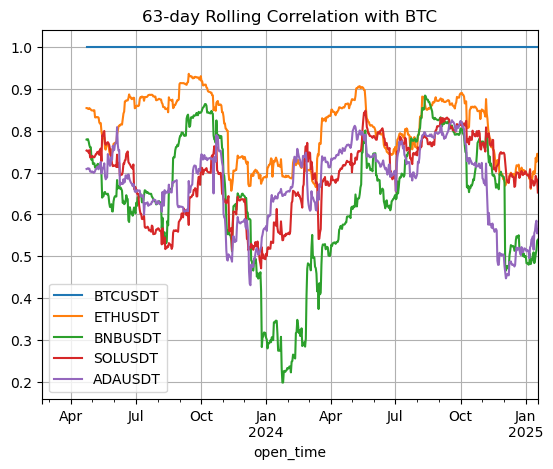

In [176]:
# Plot Rolling Correlations
plt.figure(figsize=(12, 6))
rolling_corr.plot()
plt.title('63-day Rolling Correlation with BTC')
plt.grid(True)
plt.show()

In [177]:
# Final Performance Metrics
# Calculate performance metrics
performance_metrics = pd.DataFrame({
    'Metric': [
        'Gross Sharpe Ratio',
        'Net Sharpe Ratio',
        'Maximum Drawdown',
        'Days Invested',
        'Hit Rate'
    ],
    'Value': [
        f"{np.sqrt(252) * strat_rets_gross.mean() / strat_rets_gross.std():.2f}",
        f"{np.sqrt(252) * strat_rets_net.mean() / strat_rets_net.std():.2f}",
        f"{drawdowns['Net Strategy'].min():.2%}",
        f"{(weights != 0).any(axis=1).mean():.2%}",
        f"{(strat_rets_net > 0).mean():.2%}"
    ]
})

# Calculate returns metrics
returns_metrics = pd.DataFrame({
    'Metric': [
        'Gross Return',
        'Net Return',
        'BTC Return'
    ],
    'Value': [
        f"{(cum_rets_gross.iloc[-1] - 1):.2%}",
        f"{(cum_rets_net.iloc[-1] - 1):.2%}",
        f"{(cum_rets_btc.iloc[-1] - 1):.2%}"
    ]
})

# Display tables
print("Strategy Performance Metrics:")
display(performance_metrics.set_index('Metric'))
print("\nCumulative Returns:")
display(returns_metrics.set_index('Metric'))

Strategy Performance Metrics:


,Value
Metric,
Gross Sharpe Ratio,1.93
Net Sharpe Ratio,1.69
Maximum Drawdown,-29.11%
Days Invested,99.14%
Hit Rate,48.00%



Cumulative Returns:


,Value
Metric,
Gross Return,1137.37%
Net Return,769.64%
BTC Return,326.02%


In [178]:
# Monthly Returns Analysis
monthly_returns = strat_rets_net.resample('M').agg(lambda x: (1 + x).prod() - 1)

monthly_stats = pd.DataFrame({
    'Metric': [
        'Average Monthly Return',
        'Monthly Std Dev',
        'Best Month',
        'Worst Month',
        'Positive Months',
        'Negative Months',
        'Win Rate'
    ],
    'Value': [
        f"{monthly_returns.mean():.2%}",
        f"{monthly_returns.std():.2%}",
        f"{monthly_returns.max():.2%}",
        f"{monthly_returns.min():.2%}",
        f"{(monthly_returns > 0).sum()} months",
        f"{(monthly_returns < 0).sum()} months",
        f"{(monthly_returns > 0).mean():.2%}"
    ]
})

# Display table
print("Monthly Returns Analysis:")
display(monthly_stats.set_index('Metric'))

Monthly Returns Analysis:


,Value
Metric,
Average Monthly Return,13.35%
Monthly Std Dev,39.08%
Best Month,182.56%
Worst Month,-15.78%
Positive Months,14 months
Negative Months,9 months
Win Rate,58.33%
